## Benchmarking the MSA Kernel
We are interested in understanding the training, fine-tuning, and inference-time speed / memory footprint of the Triton MSA kernel.

Note: The relative imports may be wrong if working in the AlphaFold3 repository.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import gc

import torch
import pytest
import triton

from torch import Tensor
from torch import nn
import torch.nn.functional as F
from msa import MSAPairWeightedAveraging, MSAWeightedAveragingNaive
from msa_kernel import MSAWeightedAveragingFused

In [2]:
TORCH_HAS_FP8 = hasattr(torch, 'float8_e5m2')
BATCH, N_HEADS, N_SEQ, C_HIDDEN, C_m, C_z = 1, 8, 128, 8, 64, 128
# vary seq length for fixed head and batch=4
configs_time = []
for mode in ["fwd", "bwd"]:
    configs_time.append(
        triton.testing.Benchmark(
            x_names=["N_res"],
            x_vals=[32, 64] + [128 * (k+1) for k in range(10)], # 384, 768, 1536, 3072
            line_arg="provider",
            line_vals=["triton_msa"] + ["baseline"],
            line_names=["Triton_msa"] + ["Baseline"],
            styles=[("red", "-"), ("blue", "-")],
            ylabel="Runtime (ms)",
            plot_name=f"msa-batch={BATCH}-head={N_HEADS}-c={C_HIDDEN}-N_seq={N_SEQ}-C_m={C_m}-C_z={C_z}-{mode}-time",
            args={
                "N_HEADS": N_HEADS,
                "BATCH": BATCH,
                "N_seq": N_SEQ,
                "C_HIDDEN": C_HIDDEN,
                "C_m": C_m,
                "C_z": C_z,
                "mode": mode,
            },
        )
    )


@triton.testing.perf_report(configs_time)
def bench_msa_time(BATCH, N_res, N_HEADS, N_seq, C_HIDDEN, C_m, C_z, mode, provider, device="cuda"):
    assert mode in ["fwd", "bwd"]
    warmup = 25
    rep = 100
    dtype = torch.float32
    
    m = torch.randn((BATCH, N_seq, N_res, C_m), dtype=dtype, device="cuda").requires_grad_()
    z = torch.randn((BATCH, N_res, N_res, C_z), dtype=dtype, device="cuda").requires_grad_()
    
    msa = MSAPairWeightedAveraging(
            c_msa=C_m,
            c_z=C_z,
            c_hidden=C_HIDDEN,
            no_heads=N_HEADS
          ).to(device)
    
    try: 
        if "triton_msa" in provider:
            fn = lambda: msa.forward(m, z, use_triton_kernel=True)
            if mode == "bwd":
                o = fn()
                do = torch.randn_like(o)
                fn = lambda: o.backward(do, retain_graph=True)

        elif "baseline" in provider:
            fn = lambda: msa.forward(m, z, use_triton_kernel=False)
            if mode == "bwd":
                o = fn()
                do = torch.randn_like(o)
                fn = lambda: o.backward(do, retain_graph=True)
        ms = triton.testing.do_bench(fn, warmup=warmup, rep=rep)
    # CUDA OOM
    except: 
        ms = None

    return ms


In [3]:
%matplotlib

# Run profiling for runtime
bench_msa_time.run(save_path="data/", print_data=True)

Using matplotlib backend: agg
msa-batch=1-head=8-c=8-N_seq=128-C_m=64-C_z=128-fwd-time:
     N_res  Triton_msa   Baseline
0     32.0    0.623151   0.361244
1     64.0    0.769531   0.382626
2    128.0    1.330592   1.142210
3    256.0    2.576327   4.173201
4    384.0    3.945898   9.883307
5    512.0    9.495142  17.180468
6    640.0   12.132607  27.060225
7    768.0   15.065770  38.804482
8    896.0   25.649492  52.185089
9   1024.0   29.804544  67.841026
10  1152.0   35.334656        NaN
11  1280.0   43.502594        NaN


/opt/conda/envs/triton/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


msa-batch=1-head=8-c=8-N_seq=128-C_m=64-C_z=128-bwd-time:
     N_res  Triton_msa   Baseline
0     32.0    1.131987   0.599265
1     64.0    1.137249   0.793058
2    128.0    1.136363   2.430841
3    256.0    1.778791   8.904054
4    384.0    3.214336  20.676607
5    512.0    5.209998  36.048386
6    640.0    7.459445  59.869183
7    768.0   10.382792  97.107971
8    896.0   13.998373        NaN
9   1024.0   17.698406        NaN
10  1152.0   21.931519        NaN
11  1280.0   26.280960        NaN


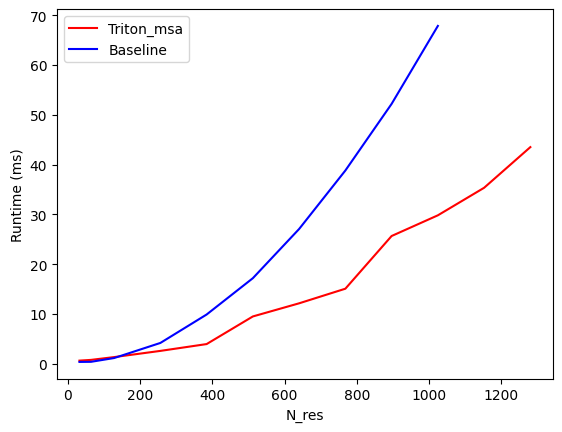

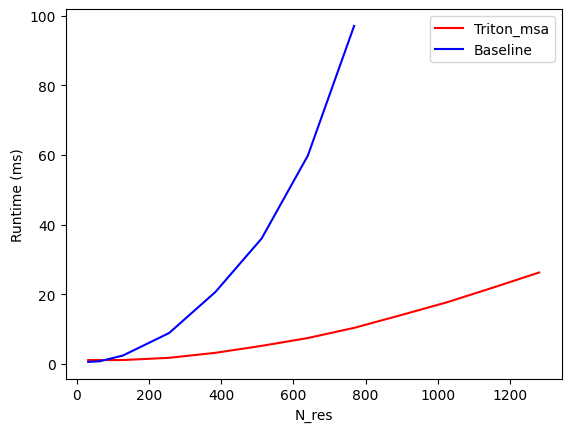

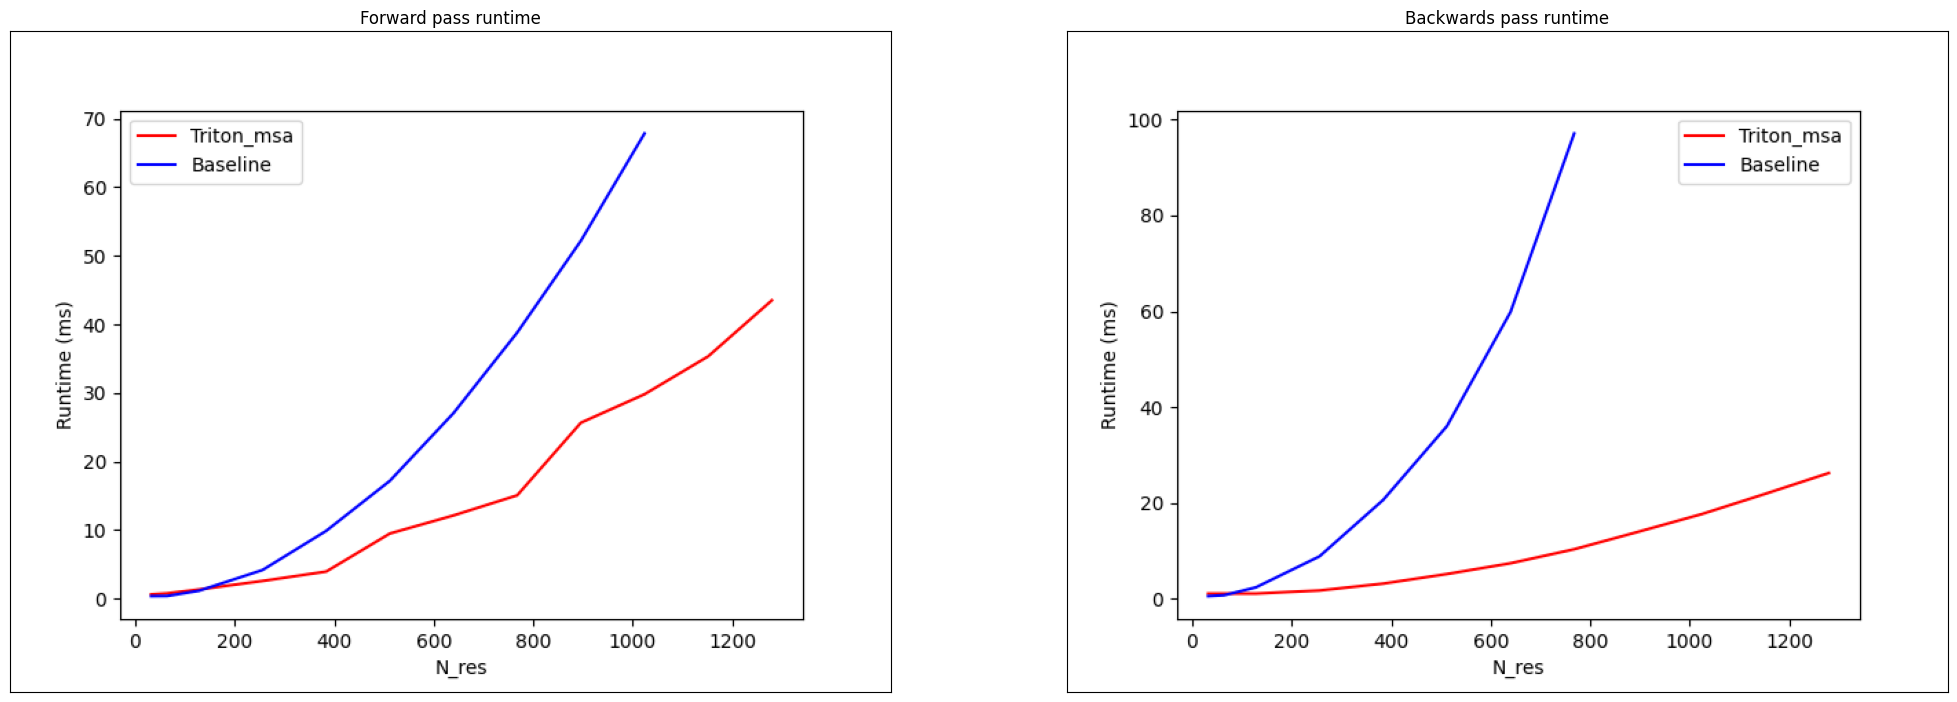

In [4]:
%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 25, 20

# read images
fwd = mpimg.imread(f"./data/msa-batch={BATCH}-head={N_HEADS}-c={C_HIDDEN}-N_seq={N_SEQ}-C_m={C_m}-C_z={C_z}-fwd-time.png")
bwd = mpimg.imread(f"./data/msa-batch={BATCH}-head={N_HEADS}-c={C_HIDDEN}-N_seq={N_SEQ}-C_m={C_m}-C_z={C_z}-bwd-time.png")

# display images
fig, ax = plt.subplots(1,2)
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    
ax[0].set_title('Forward pass runtime')
ax[0]
ax[0].imshow(fwd)
ax[1].set_title('Backwards pass runtime')
ax[1].imshow(bwd)

### Profiling peak memory usage
We plot the peak memory usage on an A100 GPU (40GB HBM).

In [5]:
BATCH, N_HEADS, N_SEQ, C_HIDDEN, C_m, C_z = 1, 8, 128, 8, 64, 128
# vary seq length for fixed head and batch=4
configs_mem = []
for mode in ["fwd", "bwd"]:
    configs_mem.append(
        triton.testing.Benchmark(
            x_names=["N_res"],
            x_vals=[32, 64] + [128 * (k+1) for k in range(50)], # 384, 768, 1536, 3072
            line_arg="provider",
            line_vals=["triton_msa"] + ["baseline"],
            line_names=["Triton_msa"] + ["Baseline"],
            styles=[("red", "-"), ("blue", "-")],
            ylabel="Peak memory usage (GB)",
            plot_name=f"msa-batch={BATCH}-head={N_HEADS}-c={C_HIDDEN}-N_seq={N_SEQ}-C_m={C_m}-C_z={C_z}-{mode}-mem",
            args={
                "N_HEADS": N_HEADS,
                "BATCH": BATCH,
                "N_seq": N_SEQ,
                "C_HIDDEN": C_HIDDEN,
                "C_m": C_m,
                "C_z": C_z,
                "mode": mode,
            },
        )
    )


@triton.testing.perf_report(configs_mem)
def bench_msa_mem(BATCH, N_res, N_HEADS, N_seq, C_HIDDEN, C_m, C_z, mode, provider, device="cuda"):
    assert mode in ["fwd", "bwd"]
    warmup = 25
    rep = 100
    dtype = torch.float32
    
    m = torch.randn((BATCH, N_seq, N_res, C_m), dtype=dtype, device="cuda").requires_grad_()
    z = torch.randn((BATCH, N_res, N_res, C_z), dtype=dtype, device="cuda").requires_grad_()
    
    msa = MSAPairWeightedAveraging(
            c_msa=C_m,
            c_z=C_z,
            c_hidden=C_HIDDEN,
            no_heads=N_HEADS
          ).to(device)
    
    try: 
        if "triton_msa" in provider:
            fn = lambda: msa.forward(m, z, use_triton_kernel=True)
            if mode == "bwd":
                o = fn()
                do = torch.randn_like(o)
                fn = lambda: o.backward(do, retain_graph=True)

        elif "baseline" in provider:
            fn = lambda: msa.forward(m, z, use_triton_kernel=False)
            if mode == "bwd":
                o = fn()
                do = torch.randn_like(o)
                fn = lambda: o.backward(do, retain_graph=True)
        
        torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.reset_peak_memory_stats()
        fn()
        peak_memory = torch.cuda.max_memory_allocated() / (2**30)
    
        
    # CUDA OOM
    except: 
        peak_memory = None

    return peak_memory


In [6]:
# Run profiling for memory
%matplotlib
bench_msa_mem.run(save_path="data/", print_data=True)

Using matplotlib backend: agg
msa-batch=1-head=8-c=8-N_seq=128-C_m=64-C_z=128-fwd-mem:
     N_res  Triton_msa   Baseline
0     32.0    0.023803   0.054106
1     64.0    0.033714   0.156881
2    128.0    0.059626   0.556204
3    256.0    0.135801   2.129934
4    384.0    0.244448   4.737112
5    512.0    0.385565   8.377737
6    640.0    0.559763  13.052420
7    768.0    0.765211  18.759329
8    896.0    1.004412  25.500967
9   1024.0    1.274740        NaN
10  1152.0    1.578211        NaN
11  1280.0    1.914152        NaN
12  1408.0    2.282564        NaN
13  1536.0    2.683447        NaN
14  1664.0    3.116800        NaN
15  1792.0    3.582624        NaN
16  1920.0    4.080919        NaN
17  2048.0    4.611685        NaN
18  2176.0    5.174921        NaN
19  2304.0    5.770628        NaN
20  2432.0    6.398806        NaN
21  2560.0    7.059454        NaN
22  2688.0    7.752573        NaN
23  2816.0    8.479139        NaN
24  2944.0    9.237078        NaN
25  3072.0   10.027487       

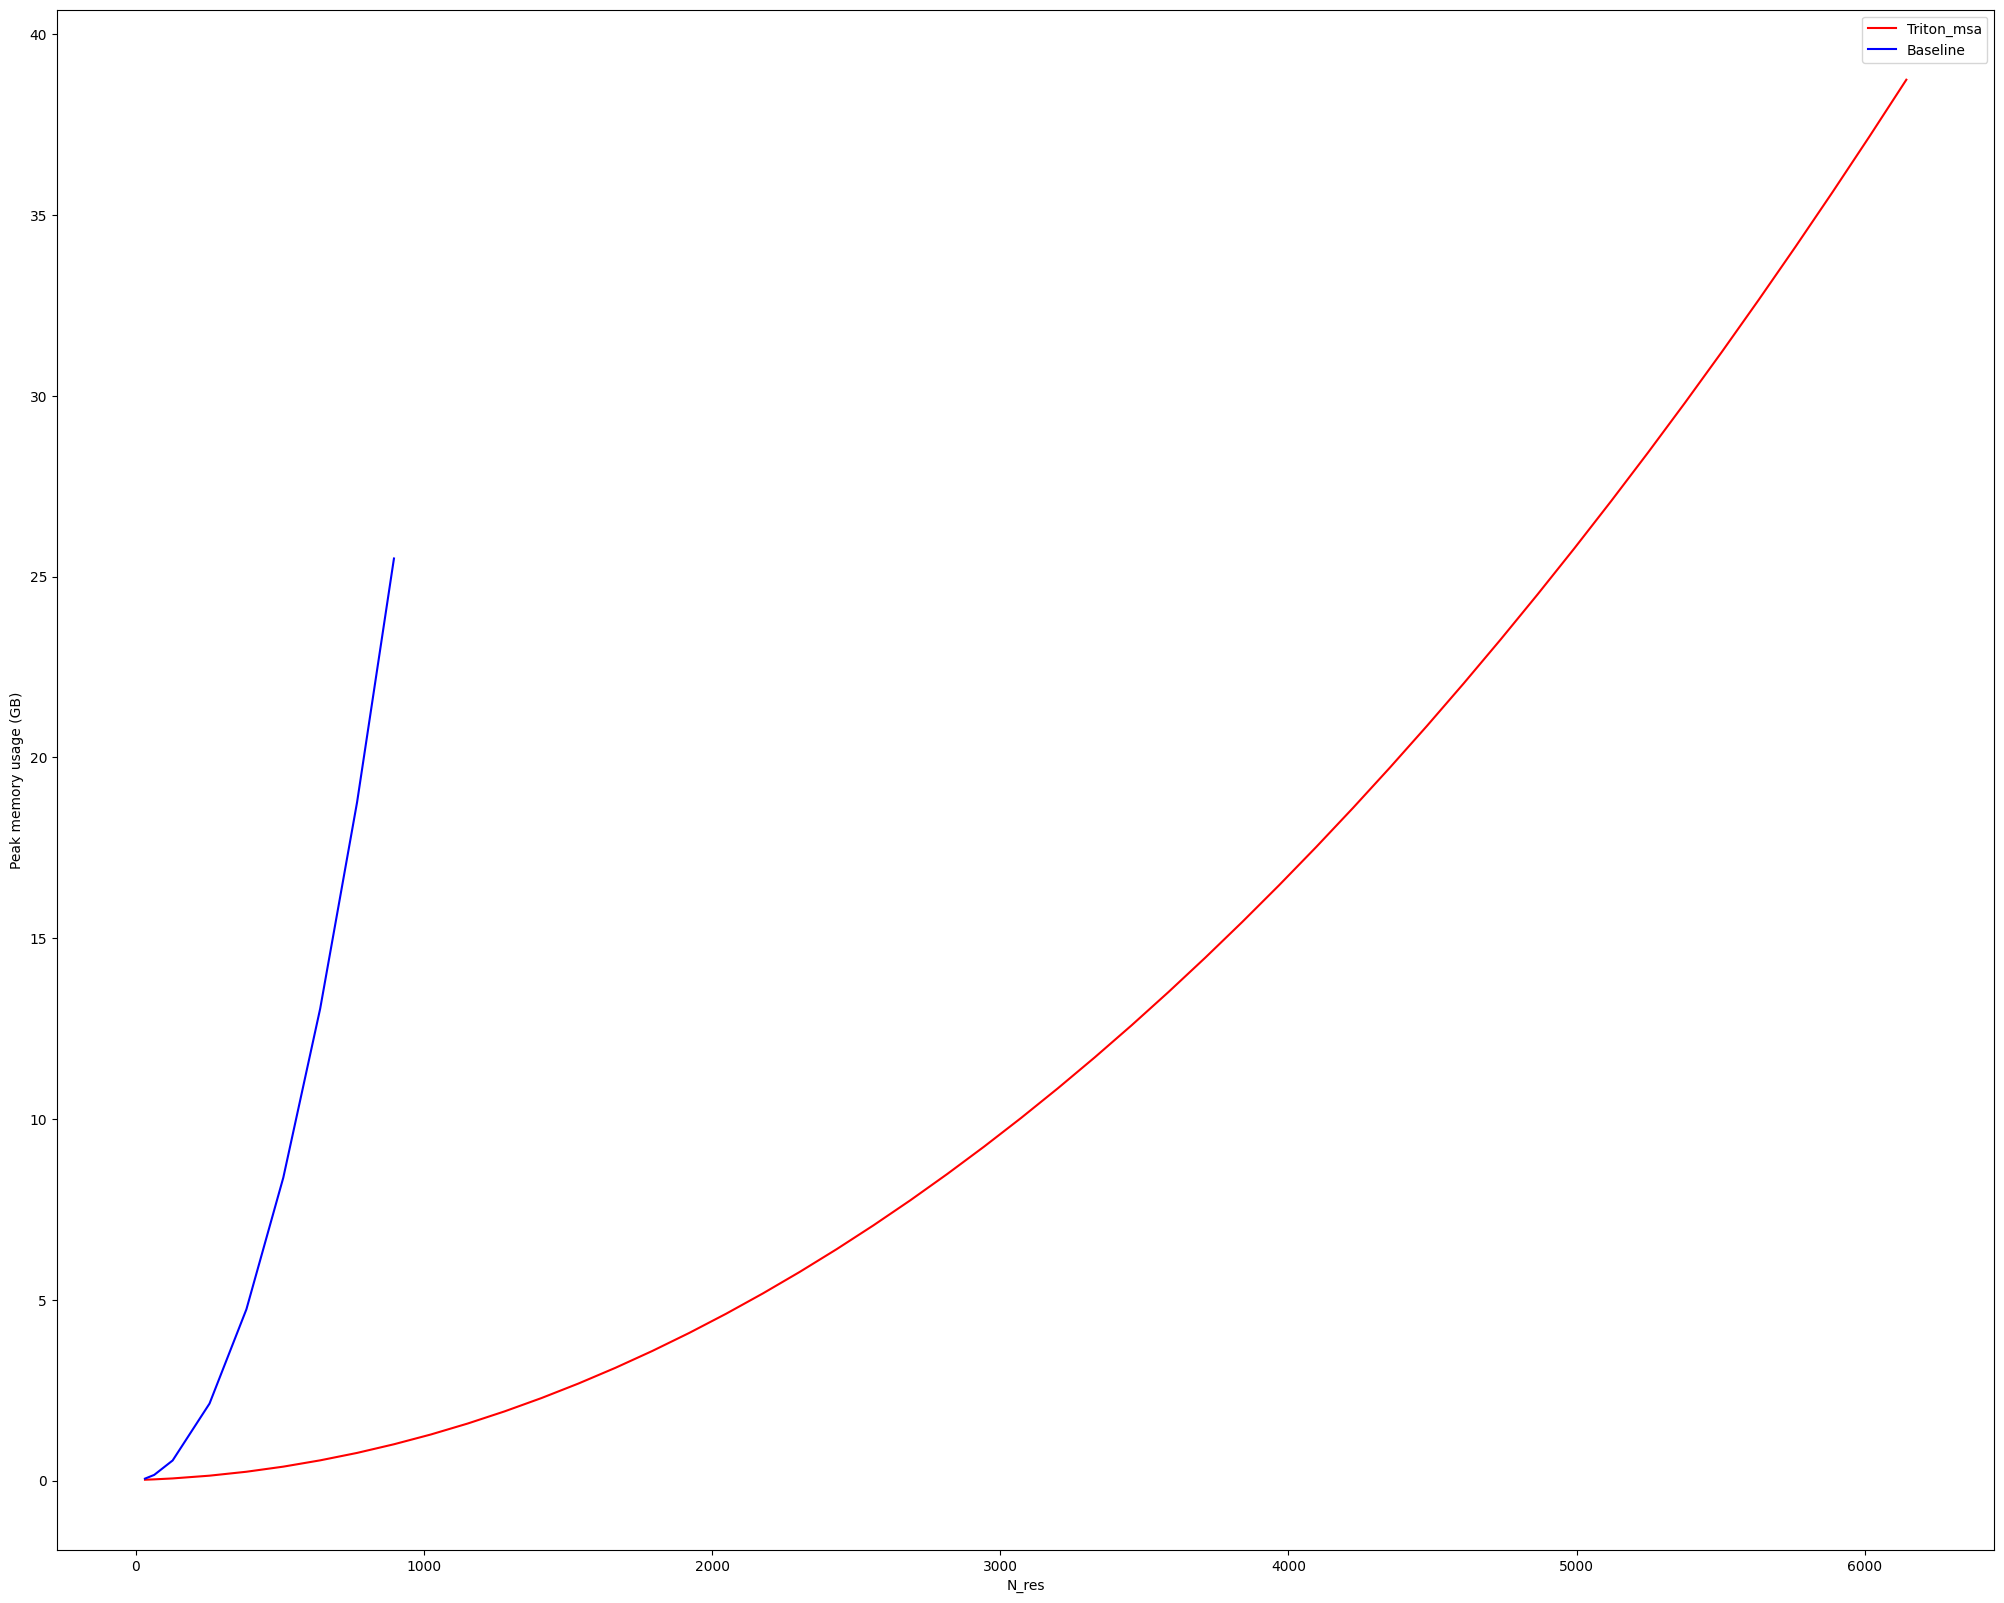

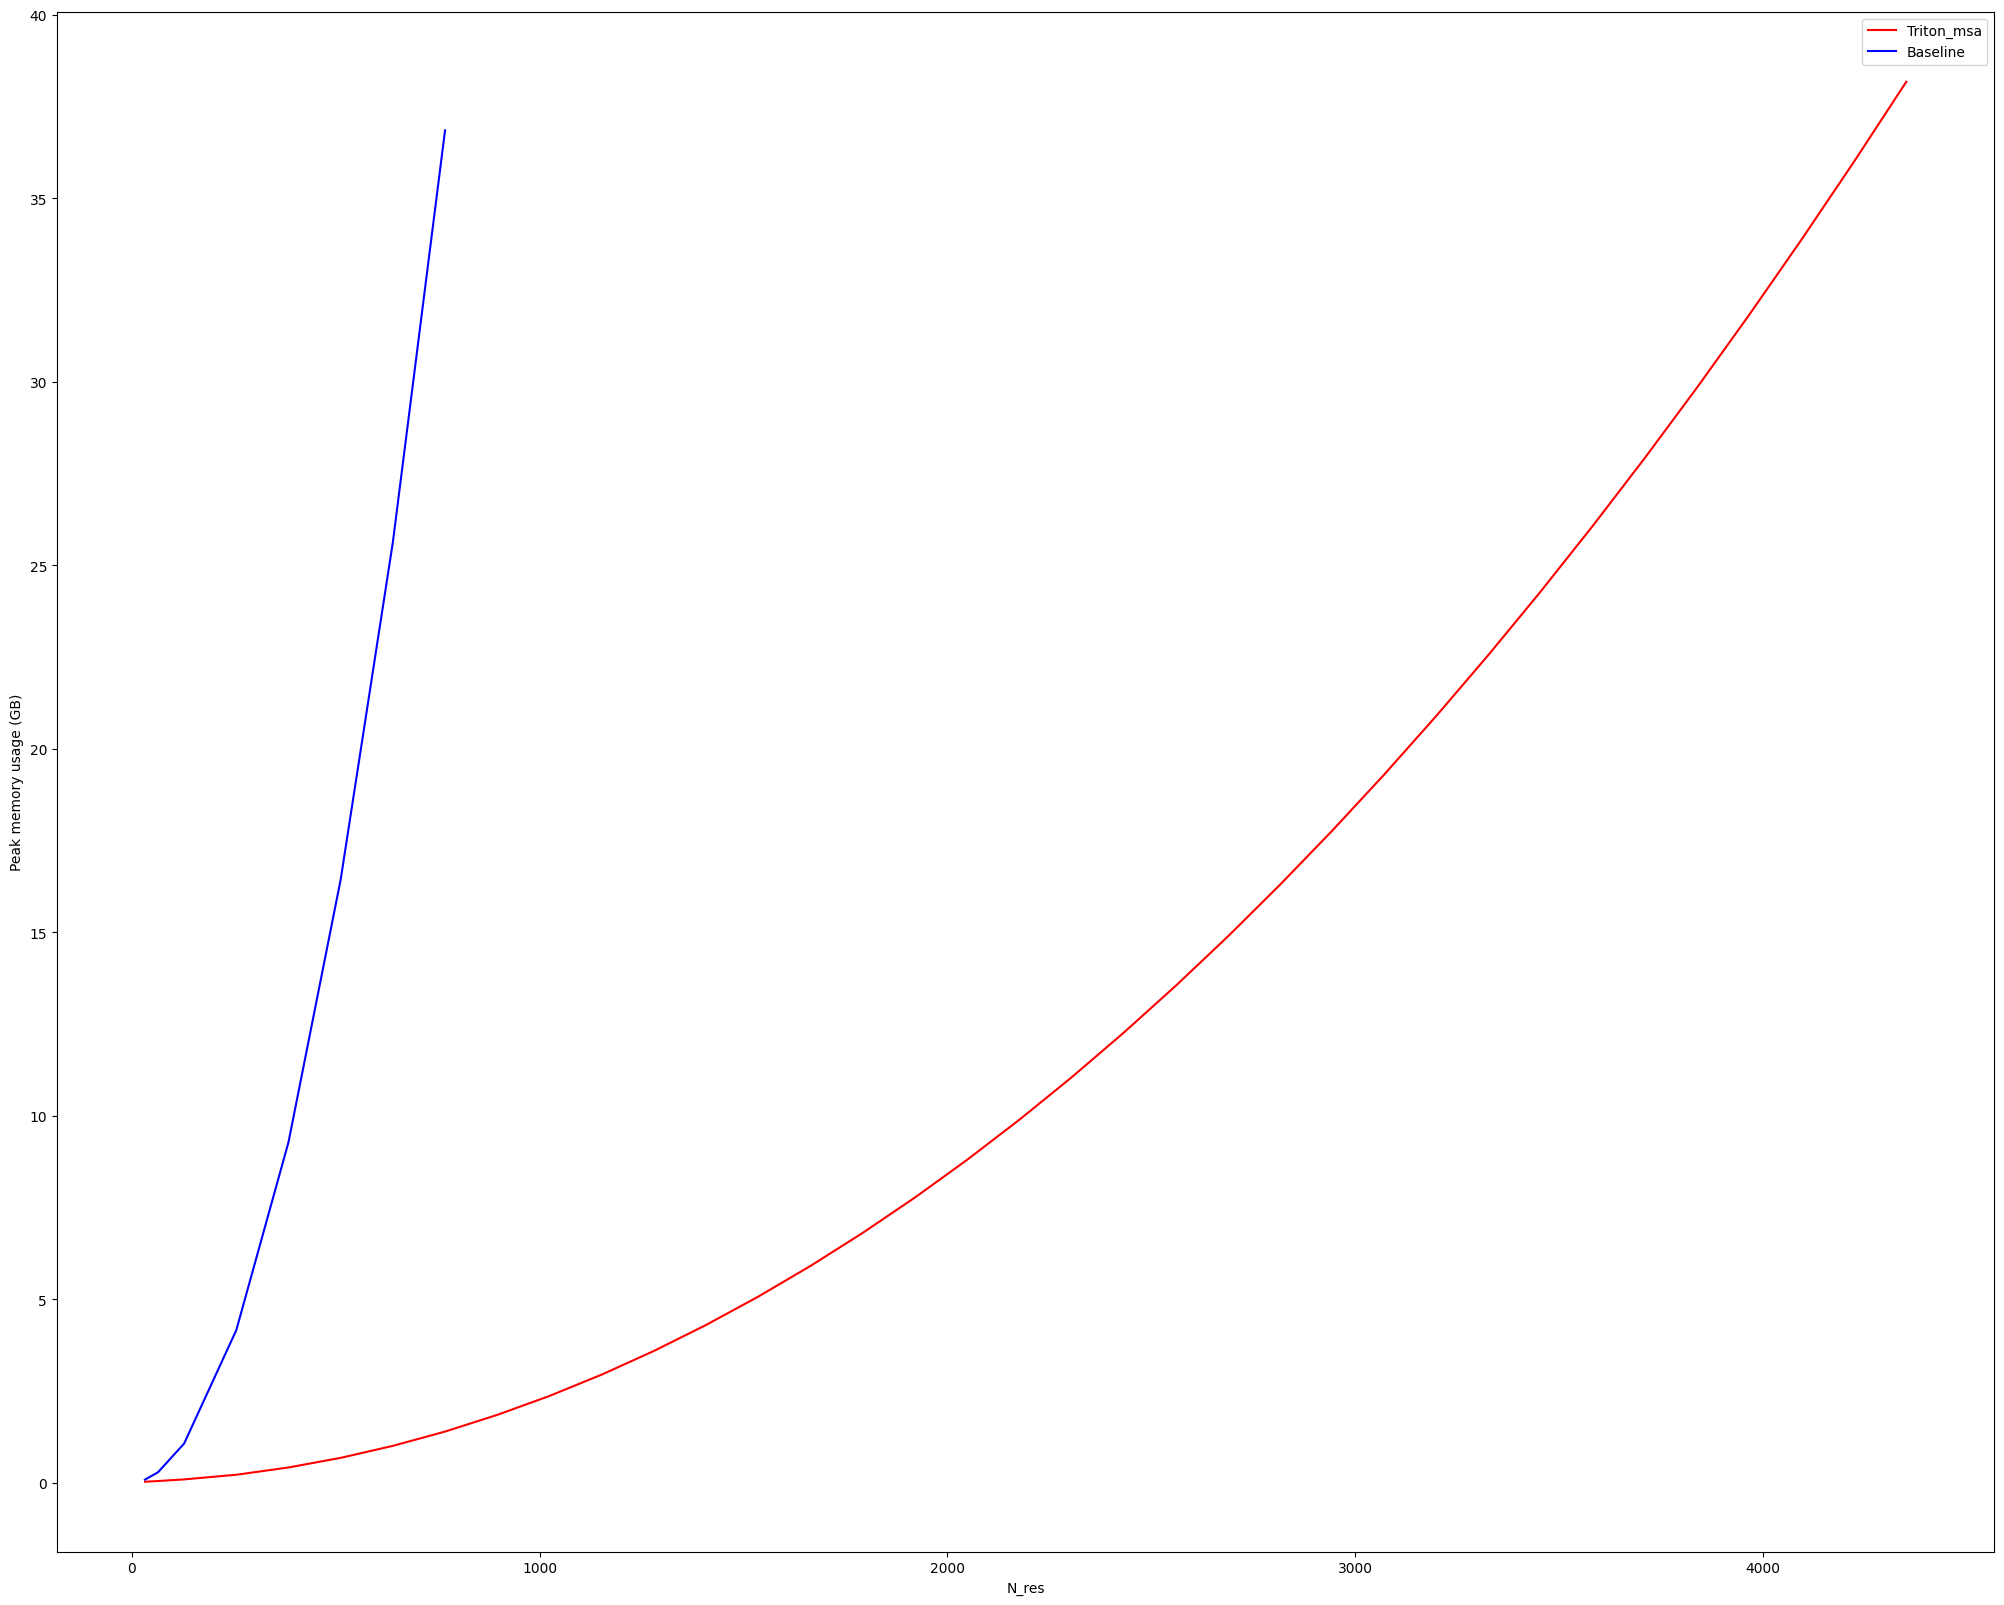

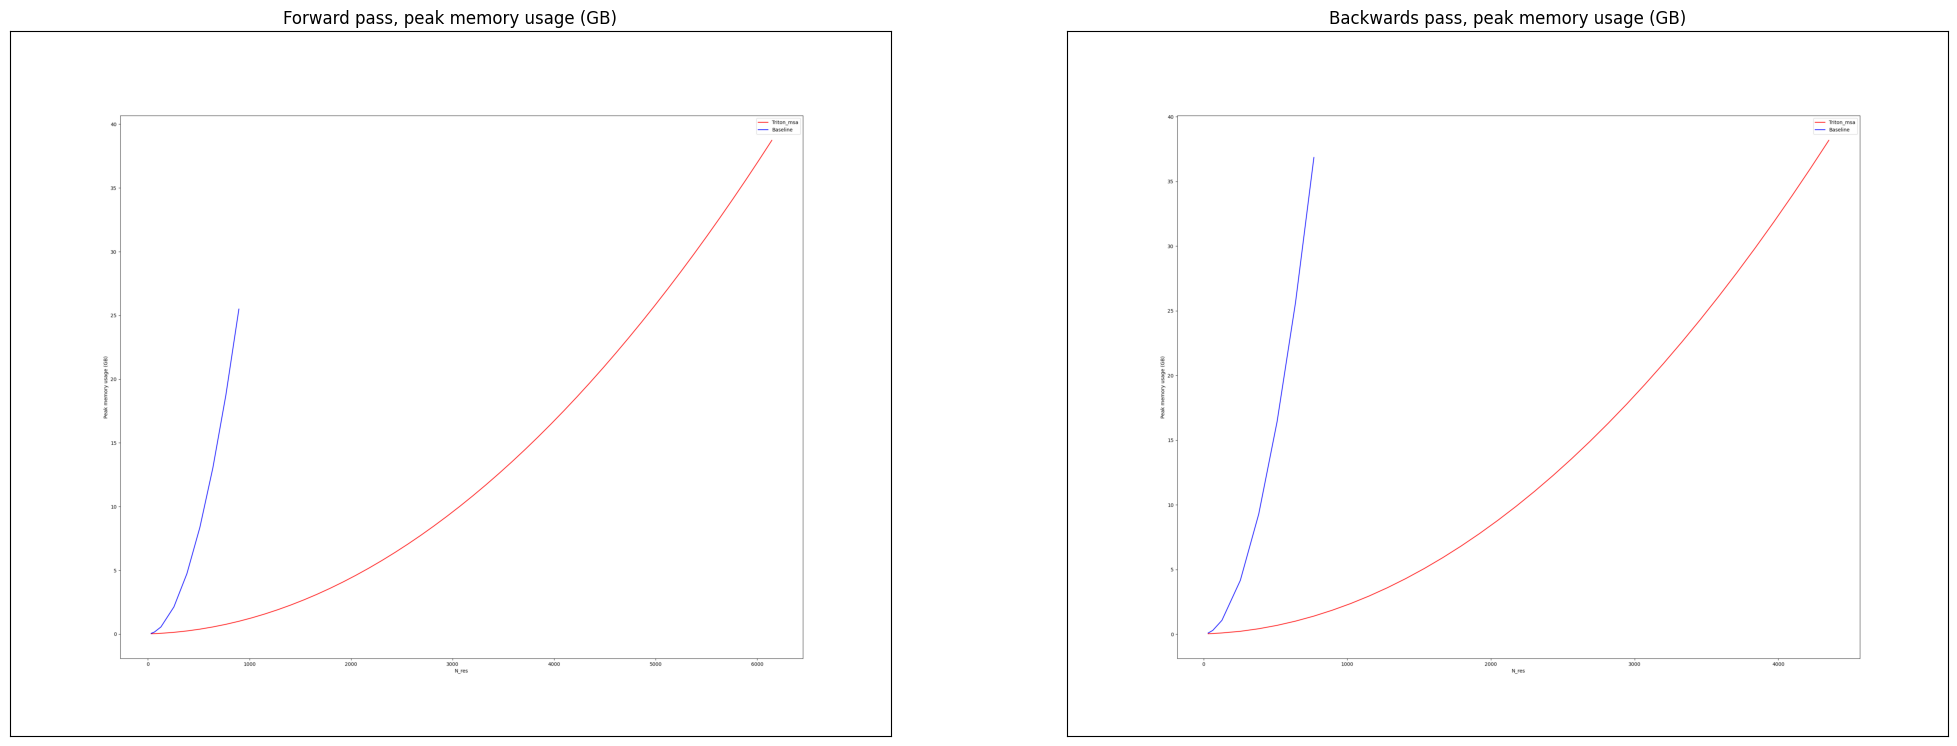

In [7]:
%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 25, 20

# read images
fwd = mpimg.imread(f"./data/msa-batch={BATCH}-head={N_HEADS}-c={C_HIDDEN}-N_seq={N_SEQ}-C_m={C_m}-C_z={C_z}-fwd-mem.png")
bwd = mpimg.imread(f"./data/msa-batch={BATCH}-head={N_HEADS}-c={C_HIDDEN}-N_seq={N_SEQ}-C_m={C_m}-C_z={C_z}-bwd-mem.png")

# display images
fig, ax = plt.subplots(1,2)
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    
ax[0].set_title('Forward pass, peak memory usage (GB)')
ax[0]
ax[0].imshow(fwd)
ax[1].set_title('Backwards pass, peak memory usage (GB)')
ax[1].imshow(bwd)